# Hamiltonian Monte Carlo Algorithm

### Density functions 

In [1]:
import autograd.numpy as np
from autograd.scipy.special import logsumexp

def neg_log_normal(mu, sigma):
    """
    logp(x | mu, sigma) = 0.5 * log(2π) + log(σ) + 0.5 * ((x - μ)/σ)^2
    """

    def logp(x):
        return 0.5 * (np.log(2 * np.pi * sigma * sigma) + ((x - mu) / sigma) ** 2)

    return logp


def neg_log_mvnormal(mu, sigma):
    """Use a Cholesky decomposition for more careful work."""

    def logp(x):
        k = mu.shape[0]
        return (
            k * np.log(2 * np.pi)
            + np.log(np.linalg.det(sigma))
            + np.dot(np.dot((x - mu).T, np.linalg.inv(sigma)), x - mu)
        ) * 0.5

    return logp


def neg_log_funnel():
    """Neal's funnel.
    The pdf is
    p(x) = N(x[0] | 0, 1) N(x[1:] | 0, exp(2 * x[0]) I )
    May cause divergences!
    """
    scale = neg_log_normal(0, 1)

    def neg_log_p(x):
        funnel_dim = x.shape[0] - 1
        if funnel_dim == 1:
            funnel = neg_log_normal(0, np.exp(2 * x[0]))
        else:
            funnel = neg_log_mvnormal(
                np.zeros(funnel_dim), np.exp(2 * x[0]) * np.eye(funnel_dim)
            )
        return scale(x[0]) + funnel(x[1:])

    return neg_log_p


def mixture(neg_log_probs, probs):
    """Log probability of a mixture of probabilities.
    neg_log_probs should be an iterator of negative log probabilities
    probs should be an iterator of floats of the same length that sums to 1-ish
    """
    probs = np.array(probs) / np.sum(probs)
    assert len(neg_log_probs) == probs.shape[0]

    def logp(x):
        return -logsumexp(np.log(probs) - np.array([logp(x) for logp in neg_log_probs]))

    return logp

### Leapfrog and Hamiltonian Monte Carlo Algorithm

In [7]:
from autograd import grad
import autograd.numpy as np
import scipy.stats as st
import math

#Leapfrog algorithm
def leapfrog(q,p,dVdq,path_len,step_size) :
    '''
    inputs :
    --------
    q,p (float)^D -> initial position and momentum
    dVdq (function)-> Gradient of velocity
    path_len (float) -> How long each integration path is
    step_size (float) -> How long each integration step shold be
    
    Outputs :
    ---------
    q,p -> new position and momentum
    '''
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq(q) / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    # momentum flip at end
    return q, -p
    


#Hamiltonian Monte Carlo Technique 
def HMC(n_samples, negative_log_prob, initial_position, path_len=1, step_size = 0.1) :
    '''
    inputs :
    --------
    n_samples (int) -> Number of samples to return
    negative_log_prob (function) -> Negative log probability to sample from
    initial_position (np.array) -> Where we start sampling from
    path_len (float) -> How long each integration path is. Smaller is faster and more correlated.
    step_size (float) -> How long each integration step is. Smaller is slower and more accurate.
    
    Outputs :
    ---------
    An array of length n_samples
    ''' 

    dVdq = grad(negative_log_prob)
    
    samples = [initial_position]
    
    momentum = st.norm(0, 1)
    
    size = (n_samples,) + initial_position.shape[:1]
    for p0 in momentum.rvs(size=size):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1],
            p0,
            dVdq,
            path_len=path_len,
            step_size=step_size,
        )

        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def neg_log_p_to_img(neg_log_p, extent=None, num=100):
    if extent is None:
        extent = (-4, 4, -4, 4)
    X, Y = np.meshgrid(np.linspace(*extent[:2], num), np.linspace(*extent[2:], num))
    Z = np.array([np.exp(-neg_log_p(j)) for j in np.array((X.ravel(), Y.ravel())).T]).reshape(X.shape)
    return Z, extent

## Gaussian density

Text(0.5, 1.0, 'Gaussian density')

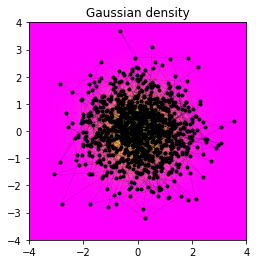

In [4]:
np.random.seed(1)

mu = np.zeros(2)
cov = np.eye(2)
neg_log_p = neg_log_mvnormal(mu,cov)

initial_position = np.array([-4.,-4.])

T = HMC(1000,neg_log_p,initial_position)
#_____________________________________
Z,extent = neg_log_p_to_img(neg_log_p)
plt.imshow(Z,extent=extent)
plt.spring()

x = [T[i][0] for i in range(len(T))]
y = [T[i][1] for i in range(len(T))]

plt.plot(x,y,c='black',marker='.',lw=0.1)
plt.title('Gaussian density')

## Mixture of 3 different Gaussian densities 

Text(0.5, 1.0, 'Mixture of Gaussian densities')

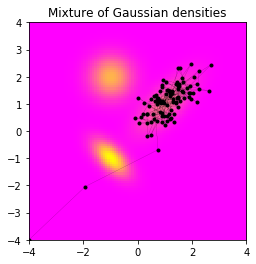

In [8]:
np.random.seed(1)

mu1 = np.ones(2)
cov1 = 0.5 * np.array([[1., 0.7],
                       [0.7, 1.]])
mu2 = -mu1
cov2 = 0.2 * np.array([[1., -0.6],
                       [-0.6, 1.]])

mu3 = np.array([-1., 2.])
cov3 = 0.3 * np.eye(2)

neg_log_p = mixture([neg_log_mvnormal(mu1, cov1), neg_log_mvnormal(mu2, cov2), neg_log_mvnormal(mu3, cov3)], [0.3, 0.3, 0.4])

initial_position = np.array([-4.,-4.])

T = HMC(100,neg_log_p,initial_position)
#_____________________________________
Z,extent = neg_log_p_to_img(neg_log_p)
plt.imshow(Z,extent=extent,origin='top')
plt.spring()

x = [T[i][0] for i in range(len(T))]
y = [T[i][1] for i in range(len(T))]

plt.plot(x,y,c='black',marker='.',lw=0.1)
plt.title('Mixture of Gaussian densities')

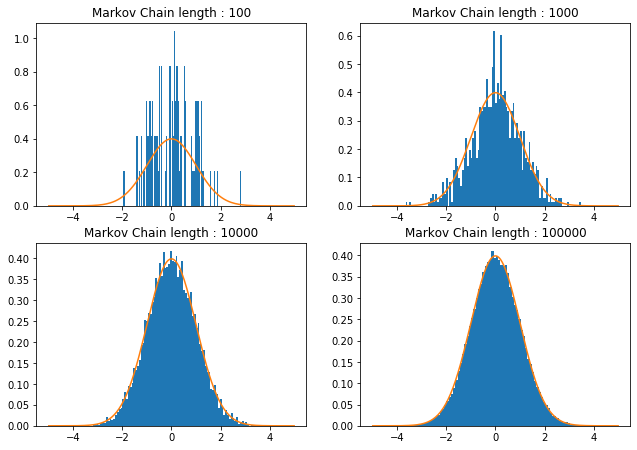

In [31]:
np.random.seed(1)

x = np.linspace(-5,5,num=200)
y = st.norm.pdf(x)

mu = np.zeros(1)
cov = np.eye(1)
neg_log_p = neg_log_mvnormal(mu,cov)

initial_position = np.array([-4.])
plt.rcParams['figure.constrained_layout.use'] = False
for i in range(4) :
    MC_length =10**(i+2)
    T = HMC(MC_length,neg_log_p,initial_position)
    plt.subplot(2,2,i+1)
    plt.hist(T,bins=100,density=True) 
    plt.plot(x,y)
    plt.title('Markov Chain length : ' + str(MC_length))
    
plt.subplots_adjust(bottom=0.1, right=1.5, top=1.5)

In [ ]:
import time
np.random.seed(1)

MCtest_list =[]
MClength_list = [10**i for i in range(1,2)]

for D in range(1,5) :
    times_MCtest = []

    mu = np.zeros(D)
    cov = np.eye(D)
    neg_log_p = neg_log_mvnormal(mu,cov)
    initial_position = 4.*np.ones(D)

    for MClength in MClength_list :
        
        t_i = time.time()
        HMC(MClength,neg_log_p,initial_position)
        t = time.time() - t_i

        times_MCtest.append(t)
    
    MCtest_list.append(times_MCtest)

In [ ]:
labels = ['D = ' + str(D) for D in range(1,5)]
for D in range(1,5):
    plt.plot(MClength_list,MCtest_list[D-1])
    plt.title('Evolution of time with MC length')
axes = plt.gca()
axes.set_xlabel('MC length')
axes.set_ylabel('Time (s)')
plt.legend(labels)

In [54]:
np.random.seed(1)

D_list = [2**i for i in range(1,10)]
times_Dtest = []
MC_length = 1000


for D in D_list :
    mu = np.zeros(D)
    cov = np.eye(D)
    neg_log_p = neg_log_mvnormal(mu,cov)
    initial_position = 4.*np.ones(D)
    
    t_i = time.time()
    HMC(MC_length,neg_log_p,initial_position)
    t = time.time() - t_i
    
    times_Dtest.append(t)

Text(0, 0.5, 'Time (s)')

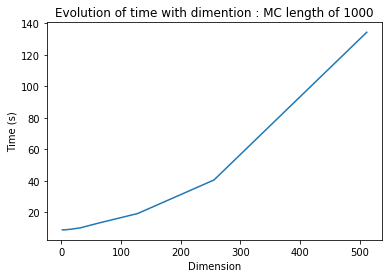

In [55]:
plt.plot(D_list,times_Dtest)
plt.title('Evolution of time with dimention : MC length of '+ str(MC_length))
axes = plt.gca()
axes.set_xlabel('Dimension')
axes.set_ylabel('Time (s)')

In [27]:
np.random.seed(1)

MClength = 10000
D = 10
mu = np.zeros(D)
cov = np.eye(D)
neg_log_p = neg_log_mvnormal(mu,cov)

initial_position = -4.0*np.ones(D)
T = (HMC(MClength,neg_log_p,initial_position))

In [28]:
S = np.cumsum(T,0)
M = [S[i]/(i+1) for i in range(len(S))]

Ssq = np.cumsum(T**2,0)
V = [Ssq[i]/(i+1) - S[i]/(i+1) for i in range(len(S))]

(-1, 1)

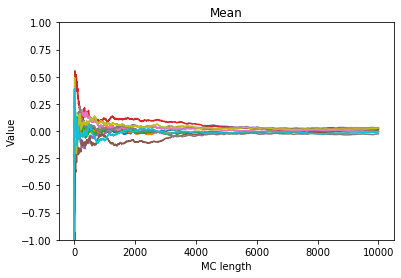

In [29]:
plt.plot(M)
axes = plt.gca()
axes.set_xlabel('MC length')
axes.set_ylabel('Value')
plt.title('Mean')
plt.ylim(-1,1)

(0.5, 1.5)

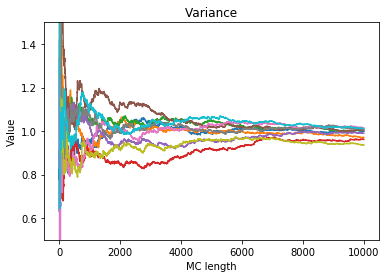

In [30]:
plt.plot(V)
axes = plt.gca()
axes.set_xlabel('MC length')
axes.set_ylabel('Value')
plt.title('Variance')
plt.ylim(0.5,1.5)

In [42]:
np.random.seed(1)
MClength = 10000

times = []
Ts = []

D_list = [2,20,50,100]
for D in D_list : 
    mu = np.zeros(D)
    cov = np.eye(D)
    neg_log_p = neg_log_mvnormal(mu,cov)

    initial_position = -4.0*np.ones(D)
    t_i = time.time()
    Ts.append(HMC(MClength,neg_log_p,initial_position))
    times.append(time.time() - t_i)

In [43]:
Ms = []
Vs = []

for T in Ts :
    S = np.cumsum(T,0)
    M = [S[i]/(i+1) for i in range(len(S))]

    Ssq = np.cumsum(T**2,0)
    V = [Ssq[i]/(i+1) - S[i]/(i+1) for i in range(len(S))]
    
    Ms.append(M)
    Vs.append(V)
        
    

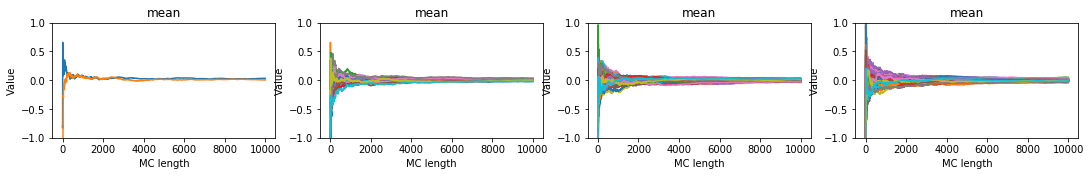

In [44]:
plt.rcParams['figure.constrained_layout.use'] = False
for i in range(len(Ts)) :
    plt.subplot(1,len(Ts),i+1)
    plt.plot(Ms[i])
    plt.title('D = ' + str(D_list[i]))
    axes = plt.gca()
    axes.set_xlabel('MC length')
    axes.set_ylabel('Value')
    plt.title('mean')
    plt.ylim(-1,1)
plt.subplots_adjust(bottom=0.1, right=2.5, top=0.5)

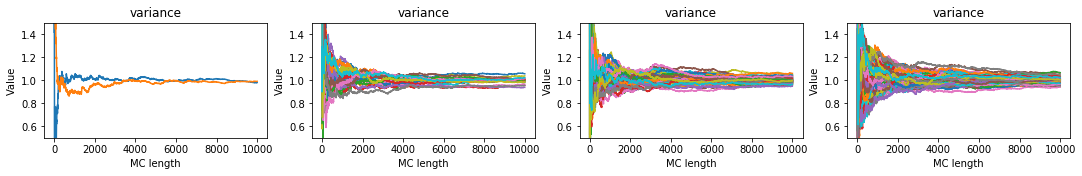

In [45]:
plt.rcParams['figure.constrained_layout.use'] = False
for i in range(len(Ts)) :
    plt.subplot(1,len(Ts),i+1)
    plt.plot(Vs[i])
    plt.title('D = ' + str(D_list[i]))
    axes = plt.gca()
    axes.set_xlabel('MC length')
    axes.set_ylabel('Value')
    plt.title('variance')
    plt.ylim(0.5,1.5)
plt.subplots_adjust(bottom=0.1, right=2.5, top=0.5)

In [46]:
times

[87.79724311828613, 96.06783771514893, 112.1674280166626, 147.45719146728516]